In [24]:
import tensorflow as tf

In [25]:
from tensorflow import keras

In [26]:
from tensorflow import keras
import matplotlib.pyplot as plt

In [27]:
print(keras.__version__)
print(tf.__version__)

2.10.0
2.10.0


In [28]:
from keras.layers import Dense, Input, Reshape, Flatten
from keras.layers import BatchNormalization
# from keras.layers.advanced_activations import LeakyReLU
from keras.layers import ELU, PReLU, LeakyReLU
from tensorflow.keras.models import Model
import matplotlib.pyplot as plt
import numpy as np 
import pandas as pd
from keras.models import Sequential
import random

In [29]:
from tensorflow.keras.optimizers import Adam

In [30]:
from keras.datasets import mnist

In [31]:
x,y = mnist.load_data()

In [32]:
img_row=28
img_col=28
img_chan=1

img_shape=(img_row, img_col, img_chan)

In [33]:
def Build_Gen():
    
    noise_shape=(100,)
    
    model=Sequential()
    
    model.add(Dense(256, input_shape=noise_shape))
    model.add(LeakyReLU(alpha=0.2))
    model.add(BatchNormalization(momentum=0.75))
    
    model.add(Dense(512))
    model.add(LeakyReLU(alpha=0.2))
    model.add(BatchNormalization(momentum=0.75))
    
    model.add(Dense(1024))
    model.add(LeakyReLU(alpha=0.2))
    model.add(BatchNormalization(momentum=0.50))
    
    model.add(Dense(512))
    model.add(LeakyReLU(alpha=0.2))
    model.add(BatchNormalization(momentum=0.75))
    
    model.add(Dense(np.prod(img_shape), activation='tanh'))
    model.add(Reshape(img_shape))
    
    model.summary()
    
    noise=Input(shape=noise_shape)
    img=model(noise)
    
    return Model(noise, img)

In [34]:
def Build_Disc():
    
    model=Sequential()
    
    model.add(Flatten(input_shape=img_shape))
    model.add(Dense(512))
    model.add(LeakyReLU(alpha=0.2))
    
    model.add(Flatten(input_shape=img_shape))
    model.add(Dense(256))
    model.add(LeakyReLU(alpha=0.2))
    
    
    model.add(Dense(128))
    model.add(LeakyReLU(alpha=0.2))
    
    model.add(Dense(1, activation='sigmoid'))
    
    model.summary()
    
    img=Input(shape=img_shape)
    score=model(img)
    
    return Model(img, score)    

In [35]:
def train(epochs, batch_size, save_interval):
    
    (x_train, _), (_,_) = mnist.load_data()
    x_train=(x_train.astype(np.float32)-127.5)/127.5
    x_train=np.expand_dims(x_train, axis=3)
    half_batch=int(batch_size/2)
    
    for epoch in range(epochs):
        
        idx=np.random.randint(0,x_train.shape[0], half_batch)
        imgs=x_train[idx]
        
        noise=np.random.normal(0,1,(half_batch,100))  
        
        gen_imgs=generator.predict(noise)
        
        d_real_loss=discriminator.train_on_batch(imgs, np.ones((half_batch,1)))
        d_fake_loss=discriminator.train_on_batch(gen_imgs, np.zeros((half_batch,1)))
        
        d_loss=0.5*np.add(d_real_loss, d_fake_loss)
        
        
        noise=np.random.normal(0,1,(batch_size,100))
        valid_y=np.array([1]*batch_size)
        
        g_loss=combined.train_on_batch(noise, valid_y)   
        
        print("%d [d_loss : %f, acc.: %.2f%%] [g_loss : %f]" %(epoch, d_loss[0], 100*d_loss[1], g_loss))
        
        if epoch%save_interval==0:
            show_imgs(epoch)

In [36]:
def show_imgs(epoch):
    r,c=5,5
    noise=np.random.normal(0,1,(r*c,100))
    gen_img=generator.predict(noise)
    
#     rescsale images
    gen_img=0.5*gen_img+0.5
    
    fig, axes = plt.subplots(r,c)
    
    cnt=0
    for i in range(r):
        for j in range(c):
            axes[i,j].imshow(gen_img[cnt,:,:,0], cmap='gray')
            cnt+=1

In [37]:
optimizer=Adam(0.0002, 0.5)

In [38]:
discriminator=Build_Disc()
discriminator.compile(loss='binary_crossentropy',
                     optimizer=optimizer,
                     metrics=['accuracy'])

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_2 (Flatten)         (None, 784)               0         
                                                                 
 dense_9 (Dense)             (None, 512)               401920    
                                                                 
 leaky_re_lu_7 (LeakyReLU)   (None, 512)               0         
                                                                 
 flatten_3 (Flatten)         (None, 512)               0         
                                                                 
 dense_10 (Dense)            (None, 256)               131328    
                                                                 
 leaky_re_lu_8 (LeakyReLU)   (None, 256)               0         
                                                                 
 dense_11 (Dense)            (None, 128)              

In [39]:
generator=Build_Gen()
generator.compile(loss='binary_crossentropy',
                 optimizer=optimizer)

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_13 (Dense)            (None, 256)               25856     
                                                                 
 leaky_re_lu_10 (LeakyReLU)  (None, 256)               0         
                                                                 
 batch_normalization_4 (Batc  (None, 256)              1024      
 hNormalization)                                                 
                                                                 
 dense_14 (Dense)            (None, 512)               131584    
                                                                 
 leaky_re_lu_11 (LeakyReLU)  (None, 512)               0         
                                                                 
 batch_normalization_5 (Batc  (None, 512)              2048      
 hNormalization)                                      

In [40]:
input_shape=Input(shape=(100,))

In [41]:
img=generator(input_shape)

In [42]:
discriminator.trainable=False

In [43]:
valid=discriminator(img)

In [44]:
valid

<KerasTensor: shape=(None, 1) dtype=float32 (created by layer 'model_3')>

In [45]:
combined=Model(input_shape, valid)
combined.compile(loss='binary_crossentropy', optimizer=optimizer)

1/1 [==============================] - 0s 283ms/step
0 [d_loss : 0.707909, acc.: 37.50%] [g_loss : 0.602318]
1/1 [==============================] - 0s 17ms/step
1 [d_loss : 0.420537, acc.: 59.38%] [g_loss : 0.589984]
1/1 [==============================] - 0s 13ms/step
2 [d_loss : 0.395307, acc.: 59.38%] [g_loss : 0.651655]
1/1 [==============================] - 0s 15ms/step
3 [d_loss : 0.334455, acc.: 87.50%] [g_loss : 0.699236]
1/1 [==============================] - 0s 17ms/step
4 [d_loss : 0.310851, acc.: 96.88%] [g_loss : 0.798929]
1/1 [==============================] - 0s 15ms/step
5 [d_loss : 0.236551, acc.: 100.00%] [g_loss : 0.930820]
1/1 [==============================] - 0s 17ms/step
6 [d_loss : 0.188145, acc.: 100.00%] [g_loss : 1.076178]
1/1 [==============================] - 0s 16ms/step
7 [d_loss : 0.197283, acc.: 100.00%] [g_loss : 1.211312]
1/1 [==============================] - 0s 15ms/step
8 [d_loss : 0.159446, acc.: 100.00%] [g_loss : 1.407387]
1/1 [==================

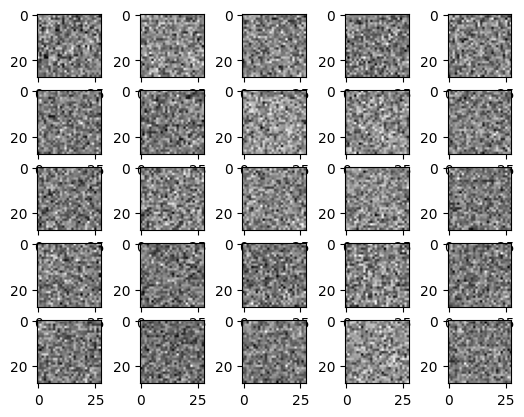

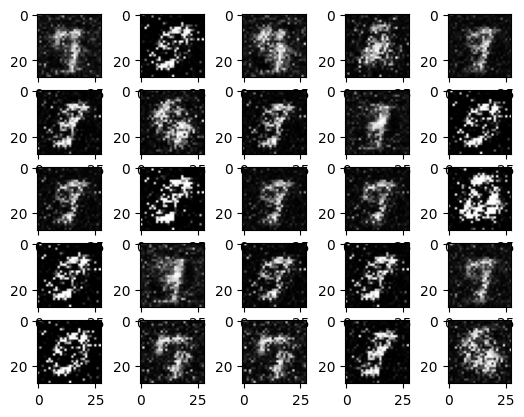

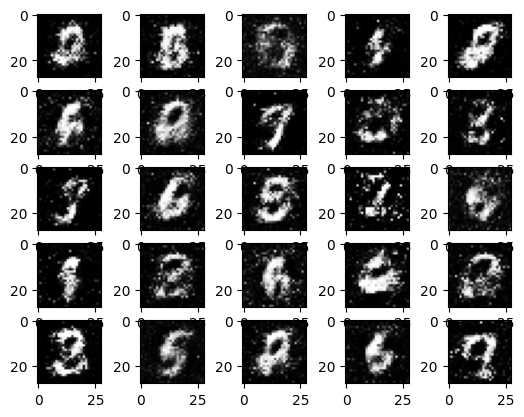

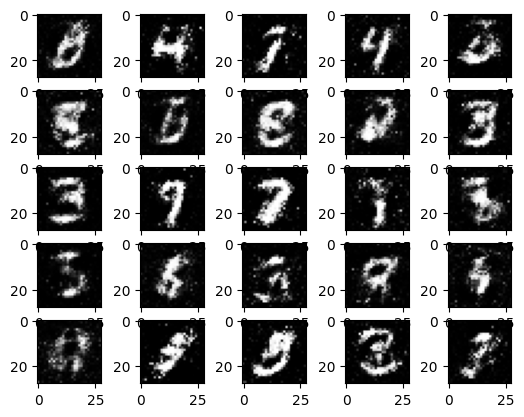

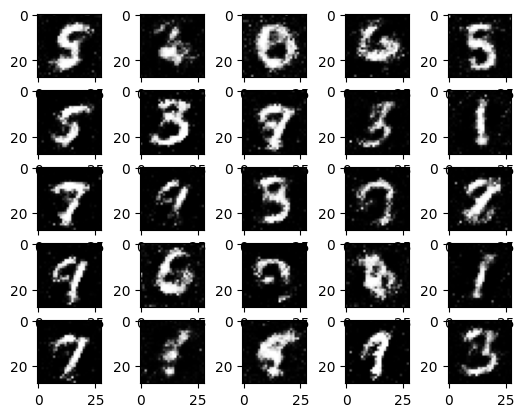

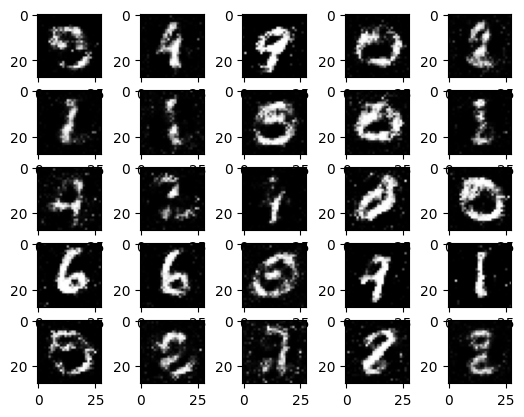

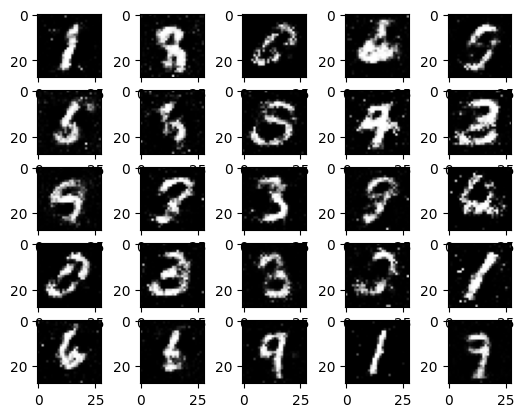

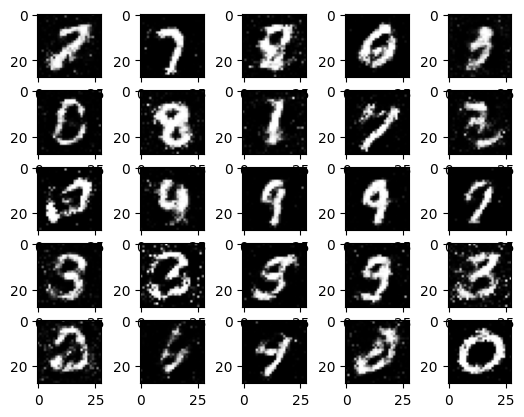

In [46]:
train(epochs=8000, batch_size=32, save_interval=1000)